# Comparison of fibroblast populations (review)

In this notebook we are going to extract and replicate the main populations from diffrent papers where fibroblast populations are described, and find similarities and differences. The premise of this analysis is that many of the populations described in different papers seem not to match, or to be transcriptomically different, but in reality they are quite similar; that is, the main types of populations are indeed shared by the different papers, which should come as no surprise.

We will use the following references to extract fibroblast information from:
* Tabib et al. 2018
* Philippeos et al. 2018
* Popescu et al. 2019
* Solé-Boldo et al. 2020
* Vorstandlechner et al. 2020
* He et al. 2020

The data from He et al was reanalyzed from fastq files with healthy donor due to the strong batch effects (the samples were already normalized / log transformed, which limits the scope of the downstream processing), and some important genes such as WIF1 were not appearing. 

## imports

In [193]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import numpy as np
import os
import triku as tk
import matplotlib.pyplot as plt
import matplotlib as mpl
import ray

In [ ]:
# To print versions of imports 

import types

def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

excludes = ['builtins', 'types', 'sys']

imported_modules = [module for module in imports() if module not in excludes]

clean_modules = []

for module in imported_modules:

    sep = '.'  # to handle 'matplotlib.pyplot' cases
    rest = module.split(sep, 1)[0]
    clean_modules.append(rest)

changed_imported_modules = list(set(clean_modules))  # drop duplicates

pip_modules = !pip freeze  # you could also use `!conda list` with anaconda

for module in pip_modules:
    name, version = module.split('==')
    if name in changed_imported_modules:
        print(name + '\t' + version)

In [ ]:
seed = 0

In [ ]:
# Palettes for UMAP gene expression

magma = [plt.get_cmap('magma')(i) for i in np.linspace(0,1, 80)]
magma[0] = (0.88, 0.88, 0.88, 1)
magma = mpl.colors.LinearSegmentedColormap.from_list("", magma[:65])

**IMPORTANT: I am running this analysis in a computer with ~500 GB of RAM. I will load many datasets at once, which might be too much for some computers. I took this decision conciously, to have as much info available at any time as possible. If you cannot run all the analysis at once, you can run it by parts.**

## data extraction and processing

In [ ]:
data_dir = os.getcwd()

### Tabib et al. 2018

#### Raw data and metadata extraction

In [ ]:
tabib_dir = data_dir + '/Tabib_2018'
os.makedirs(tabib_dir, exist_ok=True)

In [ ]:
!wget -P {tabib_dir} https://dom.pitt.edu/wp-content/uploads/2018/10/Skin_6Control_rawUMI.zip

In [ ]:
!wget -P {tabib_dir} https://dom.pitt.edu/wp-content/uploads/2018/10/Skin_6Control_Metadata.zip

In [ ]:
!unzip -o {tabib_dir}/Skin_6Control_rawUMI.zip -d {tabib_dir}

In [ ]:
!unzip -o {tabib_dir}/Skin_6Control_Metadata.zip -d {tabib_dir}

#### Adata creation and metadata gathering

In [ ]:
adata_tabib = sc.read_csv(tabib_dir + '/Skin_6Control_rawUMI.csv')
adata_tabib = adata_tabib.transpose()

In [ ]:
df_metadata_tabib = pd.read_csv(tabib_dir + '/Skin_6Control_Metadata.csv', index_col=0)

df metadata has 8366 cells, although the paper states that 8522 cells were analyzed. The rest of cells are erithrocytes, which were filtered out from the analysis.

In [ ]:
adata_tabib.raw = adata_tabib

In [ ]:
dict_reverse_mappings = {'Fibroblast': ['0', '3', '4'], 
                 'Keratinocyte': ['1', '5', '7', '11', '14',], 
                 'Endothelial cell': ['2'], 
                 'Pericyte': ['6', '10'], 
                 'Macrophage/DC': ['8'], 
                 'Lymphocyte': ['9'], 
                 'Secretory Epith': ['12'], 
                 'Smooth Muscle': ['13'], 
                 'Melanocyte': ['15'], 
                 'Neural Cell': ['16'],
                 'Cornified Env': ['17'],
                 'B cell': ['18'], 
                 'Erithrocyte': [np.NaN]}  # This is ours!

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key

In [ ]:
adata_tabib.obs['res.0.6'] = df_metadata_tabib['res.0.6'].astype(str)
adata_tabib.obs['cluster'] = [dict_mappings[i] for i in adata_tabib.obs['res.0.6']]

Since we are interested in fibros, we are going to filter their specific populations (0, 3, 4)

In [ ]:
adata_tabib_fb = adata_tabib[adata_tabib.obs['cluster'].isin(['Fibroblast']), :].copy()

In [ ]:
sc.pp.filter_genes(adata_tabib, min_counts=1)
sc.pp.log1p(adata_tabib)
sc.pp.normalize_total(adata_tabib)
tk.tl.triku(adata_tabib, n_procs=1, random_state=seed)
sc.pp.pca(adata_tabib, random_state=seed)
sc.pp.neighbors(adata_tabib, random_state=seed)
sc.tl.umap(adata_tabib, random_state=seed)

In [ ]:
sc.pl.umap(adata_tabib, color=['cluster', 'LUM', 'PDGFRA', 'COL1A1', 'DCN', 'FBLN1'], legend_loc='on data', cmap=magma, use_raw=False)

In [ ]:
# Pericyte markers, for later
sc.pl.umap(adata_tabib, color=['cluster', 'MYL9', 'RGS5'], legend_loc='on data', cmap=magma, use_raw=False)

In [ ]:
sc.pp.filter_genes(adata_tabib_fb, min_counts=1)
sc.pp.log1p(adata_tabib_fb)
sc.pp.normalize_total(adata_tabib_fb)
tk.tl.triku(adata_tabib_fb, n_procs=1, random_state=seed)
sc.pp.pca(adata_tabib_fb, random_state=seed, n_comps=30)
sc.pp.neighbors(adata_tabib_fb, random_state=seed, metric='cosine', knn=len(adata_tabib_fb) ** 0.5 // 2)

#### Labelling Tabib clusters

In the data from tabib there is no information about the fibroblast subclusters. To label them, we are going to do a broad clustering with many clusters, and gather them into bigger clusters that share the same patterns as Tabib clusters. Those clusters will not be exactly the clusters from Tabib, but will be similar enough to extract the correct biological conclusions. 

For this dataset there is a list of DEGs of the main clusters, but not the subclusters! Therefore, we will rely on the Supplementary Figure 3, which is a heatmap of the subclusters. We will use their recommended genes to do the selection. Also, clusters 4A and 4B are not divided in that heatmap, so we will do the separation based on the genes that appear on the paper.

In [ ]:
sc.tl.umap(adata_tabib_fb, min_dist=0.2, random_state=seed)
sc.tl.leiden(adata_tabib_fb, resolution=2, random_state=seed)
sc.pl.umap(adata_tabib_fb, color=['cluster', 'leiden'], legend_loc='on data')

In [ ]:
sc.pl.umap(adata_tabib_fb, color=['leiden', 'APCDD1', 'WIF1', 'WISP2', 'COMP'], legend_loc='on data', cmap=magma, use_raw=False)

We want to map clusters from leiden to cluster from Tabib. To do that, we will create a dictionary between correspondences in clusters based on markers, 
and when all correspondences are done, we will use the renamed clusters from Tabib. To simplify the processing, we will run leiden with a high resolution, and merge several clusters in one.

In [ ]:
print('T0')
sc.pl.umap(adata_tabib_fb, color=['leiden', 'WIF1', 'COMP'], cmap=magma, legend_loc='on data', use_raw=False)  # Markers of T0
print('T1')
sc.pl.umap(adata_tabib_fb, color=['leiden', 'MYOC', 'FMO1'], cmap=magma, legend_loc='on data', use_raw=False)  # Markers of T1
print('T5')
sc.pl.umap(adata_tabib_fb, color=['leiden', 'CXCL12', 'C7'], cmap=magma, legend_loc='on data', use_raw=False)  # Markers of T5                               
print('T2')
sc.pl.umap(adata_tabib_fb, color=['leiden', 'FBLN1', 'C1R', 'PI16'], cmap=magma, legend_loc='on data', use_raw=False)  # Markers of T2
print('T3')
sc.pl.umap(adata_tabib_fb, color=['leiden', 'IGFBP5', 'PLEKHH2'], cmap=magma, legend_loc='on data', use_raw=False)  # Markers of T3
print('T4a')
sc.pl.umap(adata_tabib_fb, color=['leiden', 'CRABP1', 'TNN'], cmap=magma, legend_loc='on data', use_raw=False)  # Markers of T4A
print('T4b')
sc.pl.umap(adata_tabib_fb, color=['leiden', 'COL11A1', 'UGT3A2'], cmap=magma, legend_loc='on data', use_raw=False)  # Markers of T4B
print('T6')
sc.pl.umap(adata_tabib_fb, color=['leiden', 'PCOLCE2', 'FBN1', 'SFRP4'], cmap=magma, legend_loc='on data', use_raw=False)  # Markers of T6
print('T7')
sc.pl.umap(adata_tabib_fb, color=['leiden', 'ANGPTL7', 'C2orf40'], cmap=magma, legend_loc='on data', use_raw=False)  # Markers of T7

In [ ]:
dict_reverse_mappings = {'T0': ['3', '5', '7', '14', '15', '16'], 
                 'T1': ['2', '6', '18', '20'], 
                 'T2': ['0', '11'], 
                 'T3': ['4', '9'], 
                 'T4A': ['12', '19'], 
                 'T4B': ['1'], 
                 'T5': ['8', '10'], 
                 'T6': ['13'], 
                 'T7': ['17']}

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key

In [ ]:
adata_tabib_fb.obs['tabib_clusters'] = [dict_mappings[i] for i in adata_tabib_fb.obs['leiden']]
sc.pl.umap(adata_tabib_fb, color=['tabib_clusters'], cmap=magma, legend_loc='on data')

**IMPORTANT: These clusters are not exactly the clusters from Tabib, but they are really close based on the expression of markers!**

### Philippeos et al. 2018

#### Raw data and metadata extraction

In [ ]:
phil_dir = data_dir + '/Philippeos_2018'
os.makedirs(phil_dir, exist_ok=True)

In [ ]:
!wget -P {phil_dir} https://ftp.ncbi.nlm.nih.gov/geo/series/GSE109nnn/GSE109822/suppl/GSE109822%5FCD3145%2Ecsv%2Egz

In [ ]:
!wget -P {phil_dir} https://ftp.ncbi.nlm.nih.gov/geo/series/GSE109nnn/GSE109822/suppl/GSE109822%5FCD90%2Ecsv%2Egz

In [ ]:
!gunzip {phil_dir}/*.gz -f

#### Adata creation and metadata gathering

In [ ]:
adata_phil_1 = sc.read_csv(phil_dir + '/GSE109822_CD90.csv')
adata_phil_1 = adata_phil_1.transpose()

In [ ]:
adata_phil_2 = sc.read_csv(phil_dir + '/GSE109822_CD3145.csv')
adata_phil_2 = adata_phil_2.transpose()

In [ ]:
adata_phil = sc.AnnData.concatenate(adata_phil_1, adata_phil_2)

In [ ]:
sc.pp.filter_genes(adata_phil, min_counts=1)
sc.pp.log1p(adata_phil)
sc.pp.pca(adata_phil, random_state=seed)
sc.pp.neighbors(adata_phil, random_state=seed, metric='cosine')
tk.tl.triku(adata_phil, n_procs=1, random_state=seed, use_adata_knn=True)

In [ ]:
sc.tl.umap(adata_phil, min_dist=0.5, random_state=seed)
sc.tl.leiden(adata_phil, resolution=1, random_state=seed)
sc.pl.umap(adata_phil, color=['leiden'], legend_loc='on data')

#### Labelling Philippeos clusters

In Philippeos et al. paper they detect 5 subpopulations, but 4 of them are really relevant (one of them has 5 cells). We are going to use their markers to map their populations to ours, since we do not have that information. Also, population 2 seems to be able to be subdivided into two populations. We will name them as 2A and 2B.

![](images/Phil_F6.png)

In [ ]:
dict_reverse_mappings = {'P2A': ['3'], 
                 'P2B': ['1'], 
                 'P3': ['4', '5'], 
                 'P4': ['0'], 
                 'P5': ['2'], }

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key

In [ ]:
fb_genes = ['DCN', 'LUM', 'RGS5', 'COL6A5', 'COL23A1', 'MFAP5', 'PRG4', 'DPP4', 'CD34', 'CD74', 'CLDN5']
sc.pl.umap(adata_phil, color=['leiden'] + fb_genes, legend_loc='on data', cmap=magma, )

In [ ]:
adata_phil.obs['philippeos_clusters'] = [dict_mappings[i] for i in adata_phil.obs['leiden']]
sc.pl.umap(adata_phil, color=['philippeos_clusters'], cmap=magma, legend_loc='on data')

#### Analyzing Philippeos subpopulations in more detail

We are going to analyse some of the Philippeos populations in detail, because we suspect they are not canonical fibroblasts and, instead, can be other types of cell types that have not been filtered.

In [ ]:
sc.tl.rank_genes_groups(adata_phil, groupby='philippeos_clusters', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_phil, dendrogram=False, use_raw=False, n_genes=50)

##### P2A fibroblast cluster cells are perivascular cells, not fibroblats

If we plot some of the P2A DEGs (RGS5, PDGFA, GJA4, NOTCH3, APOLD1, MT1A, PARM1) in Tabib dataset, we clearly see that they colocalize within the same cluster of perivascular cells (labelled as 'Pericyte') by Tabib. They do not colocalize with the canonical fibroblast cluster, neither appear as an interphase.

In [ ]:
peri_markers = ['RGS5', 'PDGFA', 'GJA4', 'NOTCH3', 'APOLD1', 'MT1A', 'PARM1']
sc.pl.umap(adata_phil, color=['philippeos_clusters'] + peri_markers, 
           cmap=magma, legend_loc='on data', use_raw=False) 

##### Cluster P2B does not express any relevant marker. Neither does it in the Philippeos publication. It can be a type of contamination or, in any case, irrelevant cells.

##### Cluster P5 are endothelial cells based on DEGs

In [ ]:
peri_markers = ['STC1', 'CD74', 'MCTP1', 'CTSH', 'CLDN5', 'FLT1']
sc.pl.umap(adata_phil, color=['philippeos_clusters'] + peri_markers, 
           cmap=magma, legend_loc='on data', use_raw=False) 

With that in mind, we are going to select onlt P3 and P4 populations of Philippeos to narrow down the search of fibroblast subpopulations. However, the number of cells is so low that limited resolutive power can be achieved.

In [ ]:
adata_phil_fb = adata_phil[adata_phil.obs['philippeos_clusters'].isin(['P3', 'P4']), :].copy()

In [ ]:
sc.pp.filter_genes(adata_phil_fb, min_counts=1)
tk.tl.triku(adata_phil_fb, n_procs=1, random_state=seed)
sc.pp.pca(adata_phil_fb, random_state=seed)
sc.pp.neighbors(adata_phil_fb, random_state=seed, knn=4, metric='cosine')  # 15 would be too much
sc.tl.umap(adata_phil_fb, random_state=seed)

In [ ]:
sc.tl.leiden(adata_phil_fb, resolution=0.8)
sc.pl.umap(adata_phil_fb, color='leiden')

In [ ]:
sc.pl.umap(adata_phil_fb, color=['philippeos_clusters'] + ['APCDD1', 'COL18A1', 'NKD2', 'WISP2', 'PI16', 'IGFBP6', 'SLPI'], 
cmap=magma, legend_loc='on data', use_raw=False) 

### Solé-Boldo et al. 2020

#### Raw data and metadata extraction

In [ ]:
sole_dir = data_dir + '/Sole-Boldo_2020'
os.makedirs(sole_dir, exist_ok=True)

In [ ]:
!wget -P {sole_dir} https://ftp.ncbi.nlm.nih.gov/geo/series/GSE130nnn/GSE130973/suppl/GSE130973%5Fbarcodes%5Ffiltered%2Etsv%2Egz

In [ ]:
!wget -P {sole_dir} https://ftp.ncbi.nlm.nih.gov/geo/series/GSE130nnn/GSE130973/suppl/GSE130973%5Fgenes%5Ffiltered%2Etsv%2Egz

In [ ]:
!wget -P {sole_dir} https://ftp.ncbi.nlm.nih.gov/geo/series/GSE130nnn/GSE130973/suppl/GSE130973%5Fmatrix%5Ffiltered%2Emtx%2Egz

In [ ]:
!gunzip -f {sole_dir}/GSE130973_matrix_filtered.mtx.gz {sole_dir}/GSE130973_genes_filtered.tsv.gz {sole_dir}/GSE130973_barcodes_filtered.tsv.gz

#### Adata creation and metadata gathering

In [ ]:
adata_sole = sc.read_mtx(sole_dir + '/GSE130973_matrix_filtered.mtx')
adata_sole = adata_sole.transpose()

In [ ]:
adata_sole

In [ ]:
genes_sole = pd.read_csv(sole_dir + '/GSE130973_genes_filtered.tsv', header=None, index_col=0, sep='\t')[1].values
barcodes_sole = pd.read_csv(sole_dir + '/GSE130973_barcodes_filtered.tsv', header=None,)[0].values

In [ ]:
adata_sole.var_names = genes_sole
adata_sole.obs_names = barcodes_sole

In [ ]:
adata_sole.var_names_make_unique()

In [ ]:
adata_sole.raw = adata_sole

In [ ]:
sc.pp.filter_genes(adata_sole, min_counts=1)
sc.pp.log1p(adata_sole)
sc.pp.normalize_total(adata_sole)
tk.tl.triku(adata_sole, n_procs=1, random_state=seed)
sc.pp.pca(adata_sole, random_state=seed)
sc.pp.neighbors(adata_sole, random_state=seed, metric='cosine')

In [ ]:
sc.tl.umap(adata_sole, min_dist=0.5, random_state=seed)
sc.tl.leiden(adata_sole, resolution=0.5, random_state=seed)
sc.pl.umap(adata_sole, color=['leiden'], legend_loc='on data')

In [ ]:
# GOOD MARKERS FOR FIBROBLASTS LUM AND PDGFRA
sc.pl.umap(adata_sole, color=['PDGFRA', 'LUM'], legend_loc='on data', cmap=magma)

In [ ]:
# We are going to filter the old samples and get the yound ones.
adata_sole.obs['id'] = [i[-1] for i in adata_sole.obs_names]
adata_sole.obs['age'] = ['young' if i[-1] in ['1', '2'] else 'old' for i in adata_sole.obs_names]

# We are going to remove some cells expressing S100A1, NDRG2 and 
# VAMP8, because they are technically not fibroblasts and do neither appear on the rest of datasets.
adata_sole.obs['SNV_score'] = np.sum(np.asarray(adata_sole.X[:, np.isin(adata_sole.var_names, ['S100A1', 'NDRG2', 'VAMP8'])].todense()), 1).flatten()
adata_sole = adata_sole[adata_sole.obs['SNV_score'] < 4]

adata_sole_young = adata_sole[adata_sole.obs['id'].isin(['1','2'])]
adata_sole_old = adata_sole[adata_sole.obs['id'].isin(['3', '4', '5'])]

In [ ]:
adata_sole_young_fb = adata_sole_young[adata_sole_young.obs['leiden'].isin(['0', '2', '10'])].copy()

In [ ]:
sc.pp.filter_genes(adata_sole_young_fb, min_counts=1)
tk.tl.triku(adata_sole_young_fb, n_procs=1, random_state=seed)
sc.pp.pca(adata_sole_young_fb, random_state=seed, n_comps=30)
sce.pp.bbknn(adata_sole_young_fb, batch_key='id', metric='angular')

#### Labelling Solé-Boldo clusters

In the dataset from Solé-Boldo there is no direct information about the fibroblast subclusters (there is an R object but it fails). To label them, we are going to do a broad clustering with many clusters, and gather them into bigger clusters that share the same patterns as Tabib clusters. Those clusters will not be exactly the clusters from Solé-Boldo, but will be similar enough to extract the correct biological conclusions. 

To do the assignment, we will select the list of DEGs from the Supplementary Data 3, and apply it either on old and young samples. We will select the first 10 DEGs to do the plotting.

In [ ]:
sc.tl.umap(adata_sole_young_fb, min_dist=0.3, random_state=seed)
sc.tl.leiden(adata_sole_young_fb, resolution=1.8, random_state=seed)
sc.pl.umap(adata_sole_young_fb, color=['leiden', 'id'], legend_loc='on data')

In [ ]:
sc.pl.umap(adata_sole_young_fb, color=['CCL19', 'CXCL12', 'WIF1', 'COMP', 'SLPI', 'SFRP2', 'DPP4',
                                       'WISP2', 'ANGPTL7', 'COCH', 'POSTN', 
                                       'APOE', 'TNN', 'ASPN', 'MYOC'], legend_loc='on data', cmap=magma, use_raw=False)

In [ ]:
SPap = ['APCDD1', 'COMP', 'RGS16', 'ID1', 'HBB', 'RGS2', 'COL18A1', 'DUSP1', 'WIF1', 'NKD2']
InfA = ['CXCL3', 'CXCL2', 'CXCL1', 'C11orf96', 'SOD2', 'CCL2', 'TNFAIP6', 'GEM', 'MEDAG', 'IL6']
InfB =['CCL19', 'APOE', 'PTGDS', 'APOD', 'SOCS3', 'CXCL12', 'EGR1', 'JUN', 'ABCA8', 'RARRES2']
SRet = ['WISP2', 'SLPI', 'CTHRC1', 'FBLN1', 'IGFBP6', 'PCSK1N', 'TSPAN8', 'MFAP5', 'DCN', 'CFD']
Mes = ['COCH', 'ASPN', 'POSTN', 'TNN', 'DPEP1', 'COL11A1', 'SFRP1', 'HTRA1', 'MRPS6', 'GPC3']

In [ ]:
print('SPap')
sc.pl.umap(adata_sole_young_fb, color=['leiden'] + SPap, cmap=magma, legend_loc='on data', use_raw=False)
print('Sret')
sc.pl.umap(adata_sole_young_fb, color=['leiden'] + SRet, cmap=magma, legend_loc='on data', use_raw=False)  
print('InfA')
sc.pl.umap(adata_sole_young_fb, color=['leiden'] + InfA, cmap=magma, legend_loc='on data', use_raw=False) 
print('InfB')
sc.pl.umap(adata_sole_young_fb, color=['leiden'] + InfB, cmap=magma, legend_loc='on data', use_raw=False)                      
print('Mes')
sc.pl.umap(adata_sole_young_fb, color=['leiden'] + Mes, cmap=magma, legend_loc='on data', use_raw=False)  


In [ ]:
sc.tl.rank_genes_groups(adata_sole_young_fb, groupby='leiden', )
sc.pl.rank_genes_groups_tracksplot(adata_sole_young_fb, dendrogram=False, use_raw=False)

In [ ]:
dict_reverse_mappings = {'SPap': ['1', '14', '16'], 
                 'SRet': ['0', '2', '3'], 
                 'InfA': ['5', '7', '8', '15'], 
                 'InfB': ['6', '9'], 
                 'Mes': ['4', '11', '10', '12', '13',], }

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key

In [ ]:
adata_sole_young_fb.obs['SB_clusters'] = [dict_mappings[i] for i in adata_sole_young_fb.obs['leiden']]
sc.pl.umap(adata_sole_young_fb, color=['leiden', 'SB_clusters'], cmap=magma, legend_loc='on data')

### Vorstandlechner et al. 2020

#### Raw data and metadata extraction

In [ ]:
vors_dir = data_dir + '/Vorstandlechner_2020'
os.makedirs(sole_dir, exist_ok=True)

In [ ]:
# The file was obtained by personal request from Vorstandlechner

#### Adata creation and metadata gathering

In [ ]:
adata_vors = sc.read(vors_dir + '/skin_vorstandlechner.loom', cache=True)

In [ ]:
adata_vors.obsm['tsne']  = adata_vors.obsm['tsne_cell_embeddings'] 

In [ ]:
sc.tl.rank_genes_groups(adata_vors, groupby='res_1_2', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_vors, dendrogram=False, use_raw=False)

In [ ]:
sc.pl.tsne(adata_vors, color=['res_1_2', 'FBLN1', 'PDGFRA', 'LUM', 'DCN', 'COL1A1'], cmap=magma, legend_loc='on data')

In [ ]:
adata_vors_fb = adata_vors[adata_vors.obs['res_1_2'].isin(['0', '5', '6', '11', '12', '14'])]

In [ ]:
sc.pp.filter_genes(adata_vors_fb, min_counts=1)
sc.pp.log1p(adata_vors_fb)
tk.tl.triku(adata_vors_fb, n_procs=1, random_state=seed)
sc.pp.pca(adata_vors_fb, random_state=seed, n_comps=30)
sc.pp.neighbors(adata_vors_fb, random_state=seed, knn=len(adata_vors) ** 0.5 // 2, metric='cosine')

In [ ]:
sc.tl.umap(adata_vors_fb, min_dist=0.3, random_state=seed)
sc.tl.leiden(adata_vors_fb, resolution=2, random_state=seed)
sc.pl.umap(adata_vors_fb, color=['leiden'], legend_loc='on data')

#### Labelling Vorstandlechner clusters

Since we do not have the original labellings, and most of the clsuters do not have exclusively-expressed genes, we will use some of the most useful markers to map the clusters as originally as possible.

![](images/FS1.png)

In [ ]:
FB1 = ['SLPI', 'C1QTNF3', 'MFAP5', ]  # 'PI16', 'DCN', 'CTHRC1',  'TSPAN8', 'CD55', 'PCOLCE2', 'SPARC', 'IGFBP6', 'COL1A1', 'COL3A1']
FB2 = ['JUN','FOS', 'ADH1B',]  # 'APOE','CXCL12','IGFBP7',,'C7','CCL19','RARRES2','IER2','SOCS3','CD74','IGFBP3']
FB3 = ['HSPB3','COL6A5', 'POSTN', 'RGS2',]  # 'GPC3','APOD','APCDD1','F13A1','NKD2','COL18A1', 'TSC22D3','SPRY1','BST2', 'SPARCL1','DDIT4','STMN1','CTGF']
FB4 = ['B4GALT1','JUND','HNRNPH1']  # ,'PPP1CB','C1orf56','CTNNB1','SAR1A','PTPRS','TWIST1', 'INSR','C11orf96', 'SET', 'WTAP', 'CRISPLD2']
FB5 = ['CCL2',  'DNAJA1', 'IL6', 'H2AFZ', 'GEM', 'CXCL3','CXCL2','SOD2','CXCL1','PLAUR','BIRC3',]
FB6 = ['DUSP4', 'PTGS2']  # ,'COMP', 'TNFAIP6', 'NR4A2','CEBPB','TNFAIP3','ARID5A','TGIF1','PTGS2',]

In [ ]:
sc.pl.umap(adata_vors_fb, color=['leiden'] + ['SFRP4', 'APCDD1', 'WIF1', 'WISP2', 'APOE', 'CCL19', 'COCH', 'ANGPTL7', 'TNN', 'APLN'], cmap=magma, legend_loc='on data', use_raw=False)  

In [ ]:
print('FB1')
sc.pl.umap(adata_vors_fb, color=['leiden'] + FB1, cmap=magma, legend_loc='on data', use_raw=False)
print('FB2')
sc.pl.umap(adata_vors_fb, color=['leiden'] + FB2, cmap=magma, legend_loc='on data', use_raw=False)  
print('FB3')
sc.pl.umap(adata_vors_fb, color=['leiden'] + FB3, cmap=magma, legend_loc='on data', use_raw=False) 
print('FB4')
sc.pl.umap(adata_vors_fb, color=['leiden'] + FB4, cmap=magma, legend_loc='on data', use_raw=False)                      
print('FB5')
sc.pl.umap(adata_vors_fb, color=['leiden'] + FB5, cmap=magma, legend_loc='on data', use_raw=False)  
print('FB6')
sc.pl.umap(adata_vors_fb, color=['leiden'] + FB6, cmap=magma, legend_loc='on data', use_raw=False)  

In [ ]:
dict_reverse_mappings = {
                 'FB1': ['0', '2', '3', '10', '14'], 
                 'FB2': ['1', '4', '11', '17', '18'], 
                 'FB3': ['8', '15'], 
                 'FB4': ['9', '12', '16'], 
                 'FB5': ['5', '7', '13'], 
                 'FB6': ['6']}

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key

In [ ]:
adata_vors_fb.obs['vors_clusters'] = [dict_mappings[i] for i in adata_vors_fb.obs['leiden']]
sc.pl.umap(adata_vors_fb, color=['vors_clusters'], cmap=magma, legend_loc='on data')

### He et al. 2020

**IMPORTANT: FOR SOME REASON SOME GENE SYMBOLS CHANGE HERE!!!!!!**

**WISP2 = CCN5**

#### Raw data and metadata extraction

In [ ]:
he_dir = data_dir + '/He_2020'
os.makedirs(he_dir, exist_ok=True)

In [ ]:
!rm -rf {he_dir}

In [ ]:
SRA_list = """
SRR11396171
SRR11396175
SRR11396162
SRR11396164
SRR11396166
SRR11396167
SRR11396168
SRR11396170
"""

with open(he_dir + '/accession.txt', 'w') as f:
    f.write(SRA_list)
    
df = pd.DataFrame({'name': SRA_list.split('\n')[1:-1], 'technology': ['10xv2'] * 8, 'targetnumcells': [5000] * 8})

df.to_csv(he_dir + '/metadata.tab', sep='\t', index=None)

In [ ]:
!cd {he_dir} && cat accession.txt | parallel -j 8 "prefetch {}"

In [ ]:
def adapt_fastq(filename_dir, filename_root, idx):
    # Using readline() 
    filein = open(f'{filename_dir}/{filename_root}.fastq', 'r') 
    
    fileR1 = open(f'{filename_dir}/He2020_L00{idx}_R1_001.fastq', 'w') 
    fileR2 = open(f'{filename_dir}/He2020_L00{idx}_R2_001.fastq', 'w') 
    
    print(f'{filename_dir}/{filename_root}.fastq', f'{filename_dir}/He2020_L00{idx}_R1_001.fastq')
    
    count = 0
    
    while True: 
        count += 1

        # Get next line from file 
        line = filein.readline() 
        
        if count % 4 in [1, 3]:
            fileR1.write(line.replace('\n', '') + '\n')
            fileR2.write(line.replace('\n', '') + '\n')
        elif count == 2:
            fileR1.write(line.replace('\n', '')[:26] + '\n')
            fileR2.write(line.replace('\n', '')[26:] + '\n')
        else:
            fileR1.write(line.replace('\n', '')[:26] + '\n')
            fileR2.write(line.replace('\n', '')[26:] + '\n')
            

        # if line is empty 
        # end of file is reached 
        if not line: 
            break

    filein.close() 
    fileR1.close()
    fileR2.close()
    
    os.system(f'gzip {filename_dir}/{filename_root}.fastq')
    os.system(f'gzip {filename_dir}/He2020_L00{idx}_R1_001.fastq')
    os.system(f'gzip {filename_dir}/He2020_L00{idx}_R2_001.fastq')

In [ ]:
adapt_fastq_remote = ray.remote(adapt_fastq)

ray.init(ignore_reinit_error=True, num_cpus=2)

ret = [adapt_fastq_remote.remote(f'{he_dir}', f'{name}', name_idx+1) for name_idx, name in enumerate(SRA_list.split('\n')[1:-1])]
ray.get(ret)

ray.shutdown()

In [ ]:
!loompy fromfq He2020.loom He2020 /media/seth/SETH_DATA/SETH_Alex/Programs/human_GRCh38_gencode.v31.600 metadata.tab \
He2020_L001_R1_001.fastq.gz He2020_L001_R2_001.fastq.gz He2020_L002_R1_001.fastq.gz He2020_L002_R2_001.fastq.gz \
He2020_L003_R1_001.fastq.gz He2020_L003_R2_001.fastq.gz He2020_L004_R1_001.fastq.gz He2020_L004_R2_001.fastq.gz \
He2020_L005_R1_001.fastq.gz He2020_L005_R2_001.fastq.gz He2020_L006_R1_001.fastq.gz He2020_L006_R2_001.fastq.gz \
He2020_L007_R1_001.fastq.gz He2020_L007_R2_001.fastq.gz He2020_L008_R1_001.fastq.gz He2020_L008_R2_001.fastq.gz \

#### Adata creation and metadata gathering

In [ ]:
adata_he = sc.read_loom(he_dir + '/He2020.loom')
adata_he.var_names_make_unique()

In [ ]:
# Basic QC filtering
adata_he.var['mt'] = adata_he.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_he, qc_vars=['mt'], percent_top=None, inplace=True)

In [ ]:
sc.pl.violin(adata_he, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

sc.pl.scatter(adata_he, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_he, x='total_counts', y='n_genes_by_counts')

In [ ]:
adata_he = adata_he[adata_he.obs.n_genes_by_counts < 5000, :]
adata_he = adata_he[adata_he.obs.pct_counts_mt < 25, :]

In [ ]:
sc.pp.filter_cells(adata_he, min_genes=250)

In [ ]:
sc.pp.filter_genes(adata_he, min_counts=1)
sc.pp.log1p(adata_he)
sc.pp.normalize_per_cell(adata_he)
tk.tl.triku(adata_he, n_procs=1, random_state=seed)
sc.pp.pca(adata_he, random_state=seed, n_comps=30)
sc.pp.neighbors(adata_he, random_state=seed, knn=len(adata_vors) ** 0.5 // 2, metric='cosine')

In [ ]:
sc.tl.umap(adata_he, min_dist=0.1, random_state=seed)
sc.tl.leiden(adata_he, resolution=1, random_state=seed)
sc.pl.umap(adata_he, color=['leiden'], legend_loc='on data')

In [ ]:
# Replace CCN5 by WISP2 because it is a key gene
dict_rep = {'CCN5': 'WISP2', 'ACKR1': 'DARC'}
adata_he.var_names = [dict_rep[i] if i in dict_rep else i for i in adata_he.var_names]

In [ ]:
sc.pl.umap(adata_he, color=['leiden', 'KRT5', 'COL1A1', 'RGS5', 'MLANA', 'VWF', 'S100B', 'NRXN1'], legend_loc='on data', cmap=magma, )

In [ ]:
sc.pl.umap(adata_he, color=['leiden', 'PDGFRA', 'LUM', 'DCN', 'FBLN1', 'COL1A1'], legend_loc='on data', cmap=magma, )

In [ ]:
sc.tl.rank_genes_groups(adata_he, groupby='leiden')
sc.pl.rank_genes_groups(adata_he)

Fibroblast clusters are 0, 11, 13, 18, and 23. Cluster 22 is near fibroblasts, it does not express any relevant DEG, so we will, as a caution measure, not include it.

**We have to be wary because cluster 18 is divided in two, and one half near the pericytes expresses S100B and NRXN1**.

In [ ]:
adata_he_fb = adata_he[adata_he.obs['leiden'].isin(['0', '11', '13', '18', '23'])]

In [ ]:
sc.pp.filter_genes(adata_he_fb, min_counts=1)
tk.tl.triku(adata_he_fb, n_procs=1, random_state=seed)
sc.pp.pca(adata_he_fb, random_state=seed, n_comps=30)
sc.pp.neighbors(adata_he_fb, random_state=seed, knn=len(adata_vors) ** 0.5 // 2, metric='cosine')

In [ ]:
sc.tl.umap(adata_he_fb, min_dist=0.05, random_state=seed)
sc.tl.leiden(adata_he_fb, resolution=1.3, random_state=seed)
sc.pl.umap(adata_he_fb, color=['leiden'], legend_loc='on data')

From the DEG analysis below we extract that cluster 15 is the neural cluster that we will remove, and cluster 8 does not express any relevant gene.  It coexpresses some markers with cluster 3 (GPX3, AMFR, MFAP5...), but its only unique DEG among 70 is CRIP1. We will remove that cluster as well because it is uninteresting for the analysis, and is not even a bridge cluster or something like that.

In [ ]:
sc.tl.rank_genes_groups(adata_he_fb, groupby='leiden', )
sc.pl.rank_genes_groups_tracksplot(adata_he_fb, dendrogram=False, use_raw=False, n_genes=40)

In [ ]:
sc.tl.rank_genes_groups(adata_he_fb, groupby='leiden', groups=['8'], reference='rest')
sc.pl.rank_genes_groups_tracksplot(adata_he_fb, dendrogram=False, use_raw=False, n_genes=70, )

In [ ]:
adata_he_fb = adata_he_fb[~ adata_he_fb.obs['leiden'].isin(['8', '15'])]

In [ ]:
sc.pp.filter_genes(adata_he_fb, min_counts=1)
tk.tl.triku(adata_he_fb, n_procs=1, random_state=seed)
sc.pp.pca(adata_he_fb, random_state=seed, n_comps=30)
sc.pp.neighbors(adata_he_fb, random_state=seed, knn=len(adata_vors) ** 0.5 // 2, metric='cosine')

In [ ]:
sc.tl.umap(adata_he_fb, min_dist=0.1, random_state=seed)
sc.tl.leiden(adata_he_fb, resolution=1.5, random_state=seed)
sc.pl.umap(adata_he_fb, color=['leiden'], legend_loc='on data')

#### Labelling He clusters
 2
He et al. detect 4 fibroblast subpopulations. We will use their naming based on the DEGs they show in Figure 2B.

![](images/He_F2B.png)

In [ ]:
APOE_ABCA6 = ['APOE', 'ABCA6']
FBN1_MFAP5 = ['FBN1', 'MFAP5']
COL11A1_LAMC3 =['COL11A1', 'LAMC3']
COL6A5_COL18A1 = ['COL6A5', 'COL18A1', 'CCL19']

In [ ]:
sc.pl.umap(adata_he_fb, color=['leiden'] + ['LUM', 'PDGFRA', 'FBLN1', 'NRXN1', 'GPM6B', 'WISP2'], cmap=magma, legend_loc='on data', use_raw=False)


In [ ]:
print('APOE_ABCA6')
sc.pl.umap(adata_he_fb, color=['leiden'] + APOE_ABCA6, cmap=magma, legend_loc='on data', use_raw=False)
print('FBN1_MFAP5')
sc.pl.umap(adata_he_fb, color=['leiden'] + FBN1_MFAP5, cmap=magma, legend_loc='on data', use_raw=False)  
print('COL11A1_LAMC3')
sc.pl.umap(adata_he_fb, color=['leiden'] + COL11A1_LAMC3, cmap=magma, legend_loc='on data', use_raw=False) 
print('COL6A5_COL18A1')
sc.pl.umap(adata_he_fb, color=['leiden'] + COL6A5_COL18A1, cmap=magma, legend_loc='on data', use_raw=False)                      

**INTERESTINGLY, WE CANNOT FIND EXPRESSION OF COL6A5 IN HEALTHY PREPROCESSED SAMPLES!!!!** 

However, the COL6A5 / COL18A1 cluster is somewhat well established in the rest of datasets (see in robust clusters).

In [ ]:
!wget -P {he_dir} https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4430nnn/GSM4430462/suppl/GSM4430462%5FMS%2Esample4%2Eclean%2Edata%2Etxt%2Egz
!wget -P {he_dir} https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4430nnn/GSM4430464/suppl/GSM4430464%5FMS%2Esample6%2Eclean%2Edata%2Etxt%2Egz
!wget -P {he_dir} https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4430nnn/GSM4430466/suppl/GSM4430466%5FMS%2Esample8%2Eclean%2Edata%2Etxt%2Egz
!wget -P {he_dir} https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4430nnn/GSM4430467/suppl/GSM4430467%5FMS%2Esample9%2Eclean%2Edata%2Etxt%2Egz
!wget -P {he_dir} https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4430nnn/GSM4430468/suppl/GSM4430468%5FMS%2Esample10%2Eclean%2Edata%2Etxt%2Egz
!wget -P {he_dir} https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4430nnn/GSM4430470/suppl/GSM4430470%5FMS%2Esample12%2Eclean%2Edata%2Etxt%2Egz
!wget -P {he_dir} https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4430nnn/GSM4430471/suppl/GSM4430471%5FMS%2Esample13%2Eclean%2Edata%2Etxt%2Egz
!wget -P {he_dir} https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4430nnn/GSM4430475/suppl/GSM4430475%5FMS%2Esample17%2Eclean%2Edata%2Etxt%2Egz

In [ ]:
!gunzip -f {he_dir}/*.txt.gz 

In [ ]:
adata_he_GSM4430462 = sc.read_csv(he_dir + '/GSM4430462_MS.sample4.clean.data.txt').transpose()
adata_he_GSM4430464 = sc.read_csv(he_dir + '/GSM4430464_MS.sample6.clean.data.txt').transpose()
adata_he_GSM4430466 = sc.read_csv(he_dir + '/GSM4430466_MS.sample8.clean.data.txt').transpose() 
adata_he_GSM4430467 = sc.read_csv(he_dir + '/GSM4430467_MS.sample9.clean.data.txt').transpose()
adata_he_GSM4430468 = sc.read_csv(he_dir + '/GSM4430468_MS.sample10.clean.data.txt').transpose()
adata_he_GSM4430470 = sc.read_csv(he_dir + '/GSM4430470_MS.sample12.clean.data.txt').transpose() 
adata_he_GSM4430471 = sc.read_csv(he_dir + '/GSM4430471_MS.sample13.clean.data.txt').transpose() 
adata_he_GSM4430475 = sc.read_csv(he_dir + '/GSM4430475_MS.sample17.clean.data.txt').transpose()

In [ ]:
adata_he_batches = sc.AnnData.concatenate(adata_he_GSM4430462, adata_he_GSM4430464, adata_he_GSM4430466, adata_he_GSM4430467, adata_he_GSM4430468, 
                                         adata_he_GSM4430470, adata_he_GSM4430471, adata_he_GSM4430475)

In [ ]:
sc.pp.filter_genes(adata_he_batches, min_counts=1)
sc.pp.log1p(adata_he_batches)
tk.tl.triku(adata_he_batches, n_procs=1, random_state=seed)
sc.pp.pca(adata_he_batches, random_state=seed, n_comps=30)
sce.pp.bbknn(adata_he_batches,  metric='angular')

In [ ]:
sc.tl.umap(adata_he_batches, min_dist=0.3)
sc.tl.leiden(adata_he_batches)

In [ ]:
sc.pl.umap(adata_he_batches, color=['leiden', 'COL1A1', 'PDGFRA', 'COL18A1', 'COL6A5'], cmap=magma)

Coming back to the analysis

In [ ]:
sc.tl.rank_genes_groups(adata_he_fb, groupby='leiden', )
sc.pl.rank_genes_groups(adata_he_fb, dendrogram=False, use_raw=False,)

In [ ]:
dict_reverse_mappings = {'APOE_ABCA6': ['3', '4', '5', '8', '9', '12', '17', '13'], 
                 'FBN1_MFAP5': ['0', '1', '2', '10', '15'], 
                 'COL11A1_LAMC3': ['6', '7', '16'], 
                 'COL6A5_COL18A1': ['11', '14'], 
                  }

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key

In [ ]:
adata_he_fb.obs['he_clusters'] = [dict_mappings[i] for i in adata_he_fb.obs['leiden']]
sc.pl.umap(adata_he_fb, color=['leiden', 'he_clusters'], cmap=magma, legend_loc='on data')

### Popescu et al. 2019 (This is not included in the datasets!)

This is a LARGE dataset of analysis of skin, liver and kidney, as main organs. They sequence each organ and divide between immune and non-immune populations. In our case, the non-inmune part of skin is not even considered in the paper, so we have a tabula rasa to do any analysis, we do not even need to find any population from the paper, because there are none. 

#### Raw data and metadata extraction

In [ ]:
popescu_dir = data_dir + '/Popescu_2019'
os.makedirs(popescu_dir, exist_ok=True)

In [ ]:
!rm -rf {popescu_dir}

In [ ]:
!wget -P {popescu_dir} https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-7407/E-MTAB-7407.processed.1.zip
!wget -P {popescu_dir} https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-7407/E-MTAB-7407.processed.2.zip
!wget -P {popescu_dir} https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-7407/E-MTAB-7407.processed.3.zip
!wget -P {popescu_dir} https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-7407/E-MTAB-7407.processed.4.zip

In [ ]:
!unzip -o {popescu_dir}/E-MTAB-7407.processed.1.zip -d {popescu_dir} 
!unzip -o {popescu_dir}/E-MTAB-7407.processed.2.zip -d {popescu_dir}
!unzip -o {popescu_dir}/E-MTAB-7407.processed.3.zip -d {popescu_dir} 
!unzip -o {popescu_dir}/E-MTAB-7407.processed.4.zip -d {popescu_dir} 

We are going to select samples that belong to skin and that are CD45- (to exclude immune, since fibro populations are CD45-)

In [ ]:
selected_files = ['4834STDY7002880', '4834STDY7038753', 'FCAImmP7241241', 'FCAImmP7316888', 'FCAImmP7316897', 'FCAImmP7352190', 'FCAImmP7352191', 
                  'FCAImmP7462241']

for file in os.listdir(popescu_dir):
    exists = False
    for f in selected_files:
        if f in file:
            exists = True
    
    if not exists:
        os.remove(popescu_dir + '/' + file)

In [ ]:
!ls {popescu_dir}

In [ ]:
for file in selected_files:
    os.system(f"tar -zxvf {popescu_dir}/{file}.tar.gz -C {popescu_dir}")

#### Adata creation and metadata gathering

In [ ]:
adata_popescu_4834STDY7002880 = sc.read_10x_mtx(popescu_dir + '/4834STDY7002880/GRCh38')
adata_popescu_4834STDY7038753 = sc.read_10x_mtx(popescu_dir + '/4834STDY7038753/GRCh38')
adata_popescu_FCAImmP7241241 = sc.read_10x_mtx(popescu_dir + '/FCAImmP7241241/GRCh38')
adata_popescu_FCAImmP7316888 = sc.read_10x_mtx(popescu_dir + '/FCAImmP7316888/GRCh38')
adata_popescu_FCAImmP7316897 = sc.read_10x_mtx(popescu_dir + '/FCAImmP7316897/GRCh38')
adata_popescu_FCAImmP7352190 = sc.read_10x_mtx(popescu_dir + '/FCAImmP7352190/GRCh38')
adata_popescu_FCAImmP7352191 = sc.read_10x_mtx(popescu_dir + '/FCAImmP7352191/GRCh38')
adata_popescu_FCAImmP7462241 = sc.read_10x_mtx(popescu_dir + '/FCAImmP7462241/GRCh38')

In [ ]:
adata_popescu = sc.AnnData.concatenate(adata_popescu_4834STDY7002880, adata_popescu_4834STDY7038753, adata_popescu_FCAImmP7241241, 
                                       adata_popescu_FCAImmP7316888, adata_popescu_FCAImmP7316897, adata_popescu_FCAImmP7352190, 
                                       adata_popescu_FCAImmP7352191, adata_popescu_FCAImmP7462241)

In [ ]:
adata_popescu.raw = adata_popescu

In [ ]:
sc.pp.filter_genes(adata_popescu, min_counts=1)
sc.pp.log1p(adata_popescu)
tk.tl.triku(adata_popescu, n_procs=1, random_state=seed)
sc.pp.pca(adata_popescu, random_state=seed, n_comps=30)
sce.pp.bbknn(adata_popescu, metric='angular')

In [ ]:
sc.tl.umap(adata_popescu, min_dist=0.3, random_state=seed)
sc.tl.leiden(adata_popescu, resolution=1.5, random_state=seed)
sc.pl.umap(adata_popescu, color=['leiden', 'batch'], legend_loc='on data')

In [ ]:
sc.pl.umap(adata_popescu, color=['leiden', 'RGS5', 'MYL9', 'NDUFA4L2', 'NPY', 'CHRNA1', 'S100B', 'MPZ'], legend_loc='on data', cmap=magma, use_raw=False)

In [ ]:
sc.pl.umap(adata_popescu, color=['leiden', 'KRT18', 'KRT5', 'MLANA', 'CLDN5', 'PECAM1'], legend_loc='on data', cmap=magma, use_raw=False)

In [ ]:
sc.pl.umap(adata_popescu, color=['leiden', 'GINS2', 'PCNA', 'MCM3', 'NASP', 'DEK', 'HELLS', 'DUT'], legend_loc='on data', cmap=magma, use_raw=False)

We see that clusters in the surroundings (16, 17, 19, 20, 21, 22) barely express LUM or PDGFRA, so they ar not good candidates for being fibroblasts. 
* 16, 21: Pericytes - MYL9, RGS5, NDUFA4L2
* 19 - Neurons (NPY, CHRNA1, CHODL) 
* 17, 22: Schwann cells (S100B, MPZ) 
* 20, 21: Keratinocytes (KRT18, KRT5) 
* 22: Melanocytes (MLANA, TYRP)
* 21: Endothelial cells - CLDN5, PECAM1, CDH5 + Keratinocytes

Additionally, clusters 3, 11, 12, 18 express genes that are involved in cell cycle:
* GINS2 - DNA Replication Complex GINS Protein PSF2
* MCM3/5/7 - Minichromosome Maintenance Complex Component: involved in the initiation of eukaryotic genome replication
* PCNA - Proliferating Cell Nuclear Antigen: increase the processivity of leading strand synthesis during DNA replication
* NASP: encodes a H1 histone binding protein that is involved in transporting histones into the nucleus of dividing cells
* DEK: This protein binds to cruciform and superhelical DNA and induces positive supercoils into closed circular DNA
* HELLS - Helicase, Lymphoid Specific: DNA strand separation, including replication, repair, recombination, and transcription
* DUT: providing a precursor (dUMP) for the synthesis of thymine nucleotides needed for DNA replication.

We will remove those clusters from the analysis, because we are focused on populations as similar as the adult populations. Also, cluster 13 is mixed with other fibroblast clusters, so we will include it just in case.


In [ ]:
sc.tl.rank_genes_groups(adata_popescu, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_popescu, dendrogram=False, n_genes=20, use_raw=False)

In [ ]:
adata_popescu_fb = adata_popescu[adata_popescu.obs['leiden'].isin(['0', '1', '2', '4', '5', '6', '7', '8', '9', '10', '13', '14', '15'])]

In [ ]:
sc.pp.filter_genes(adata_popescu_fb, min_counts=1)
sc.pp.pca(adata_popescu_fb, random_state=seed, n_comps=30)
sce.pp.bbknn(adata_popescu_fb, metric='angular')
tk.tl.triku(adata_popescu_fb, n_procs=1, random_state=seed, use_adata_knn=True)

In [ ]:
sc.tl.umap(adata_popescu_fb, min_dist=0.3, random_state=seed)
sc.tl.leiden(adata_popescu_fb, resolution=1.5, random_state=seed)
sc.pl.umap(adata_popescu_fb, color=['leiden'], legend_loc='on data')

## Getting robust clusters

We see that all datasets have similar cell types, but the number of clusters is inconsistent. In this section we are going to do a reclustering of the datasets based on the leiden clustering. To do the reclustering, we will get the DEGs between all small clusters, and we will join two or more clusters if they do not have any distinct DEG. We will repeat the procedure until we find no more clusters without DEGs. We will aim to get between 10 to 15 clusters, although in later steps they might be further down reduced.

### Tabib et al. 2018

In [ ]:
sc.tl.rank_genes_groups(adata_tabib_fb, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_tabib_fb, dendrogram=False, n_genes=80, use_raw=False)

* Clusters 0, 11, 13 can be tentativaly be joined, however, each expresses exclusive DEGs that can be considered. 13 can be joined to 11
    * 0 - Most genes are also expressed in 11, 7, 13, etc. but the main expression of some of them is at 0.
    * 11 - NOVA1, FBN1, ABI3BP, CRIP1, TNXB , CLEC3B, CD248
    * 13 - SFRP4, PCOLCE2 -> Genes have minor expression
* Clusters 2 and 6 can be tentatively be joined, but they have different markers, so at a first pace we will not.
* Cluster 3 is always coexpressed with 5 and 15.
* Cluster 4 is almost always coexpressed with 19. It expresses, either alone or with cluster 12, BCHE, DIRAS3, DIO2, all enzymes known in thyroid or liver, not ion skin. Also, their expression is low, so we can *safely* join the two clusters. 12 should not be join because it has its own set of expressed genes.
* Clusters 8 and 9 can be joined. Cluster 8 exclusively expressed CCL19, but cluster 9 has no relevant DEG, and should be joined.
* Clusters 6 and 10 can be joined. Generally, 10 coexpresses with 6, 8, and 9, but there are genes like FMO1, C7 or LSP1 that are more *exclusive* of 10 and 6.
* Cluster 7 and 14 are always coexpressed. Sometimes 7/14 are not coexpressed with 3/5/15, so we will keep them separate so far.
* 16 is a tricky cluster, because it expresses genes from cluster 5, 11, and 0, that is, genes that are expressed in the whole DPP4/SFRP2 cluster. It can be joined to either 14, 11, 3, or any other SFRP2 cluster. To make the visualization balanced, we are going to join it to 7 / 14.
* Cluster 18 is a bridge between cluster 17(+1+6) (TAGLN, ITM2A, AKAP12), 11 (TSPAN8, CHRDL1). 
* Cluster 20 is a mixture between clusters 1, 2, 17.

In [ ]:
dict_reverse_mappings = {'T0': ['0'], 'T1': ['1'], 'T2': ['2'], 'T3': ['3', '5', '15'], 
                         'T4': ['4', '19'], 'T5': ['6', '10'], 'T6': ['7', '14', '16'], 'T7': ['8', '9'], 
                         'T8': ['11'], 'T9':['12'], 'T10':['13'], 'T11':['17'], 'T12':['18'], 'T13':['20']}

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key
        
adata_tabib_fb.obs['robust_clustering_1'] = [dict_mappings[i] for i in adata_tabib_fb.obs['leiden']]
sc.pl.umap(adata_tabib_fb, color=['robust_clustering_1'], cmap=magma, legend_loc='on data')

In [ ]:
sc.pl.umap(adata_tabib_fb, color=['robust_clustering_1',  'CCL2', 'GGT5'], cmap=magma, legend_loc='on data', use_raw=False)

In [ ]:
genes = ['GDF10', 'PLA2G2A']
sc.pl.umap(adata_tabib_fb, color=['robust_clustering_1'] + genes, cmap=magma, legend_loc='on data', use_raw=False) 

In [ ]:
sc.tl.rank_genes_groups(adata_tabib_fb, 'robust_clustering_1', method='wilcoxon')
sc.pl.rank_genes_groups(adata_tabib_fb)

In [ ]:
sc.tl.rank_genes_groups(adata_tabib_fb, 'robust_clustering_1', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_tabib_fb, dendrogram=False,  n_genes=60, use_raw=False)

In [ ]:
dict_reverse_mappings = {'A': ['T0', 'T3', 'T6', 'T8', 'T10'], 'B': ['T2', 'T5', 'T7', 'T12'], 'C': ['T1', 'T4', 'T9', 'T11'], 'D': ['T13', 'T12']}

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key
        
adata_tabib_fb.obs['axes'] = [dict_mappings[i] for i in adata_tabib_fb.obs['robust_clustering_1']]

adata_tabib_fb.uns['axes_colors'] = ['#9a1549', '#00764b', '#002562', '#606060']

sc.pl.umap(adata_tabib_fb, color=['axes'], cmap=magma, legend_loc='on data', legend_fontsize=16)

In [ ]:
sc.tl.rank_genes_groups(adata_tabib_fb, 'axes', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_tabib_fb, dendrogram=False,  n_genes=60, use_raw=False)

... storing 'clusters' as categorical


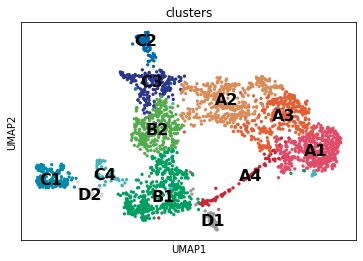

In [194]:
dict_reverse_mappings = {'A1': ['T8', 'T0'], 'A2': ['T3'], 'A3': ['T6'], 'A4': ['T10'], 
                         'B1': ['T2', 'T5'], 'B2': ['T7'], 
                         'C1': ['T1'], 'C2': ['T9'], 'C3': ['T4'], 'C4': ['T11'], 
                         'D1': ['T12'], 'D2': ['T13']}

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key
        
adata_tabib_fb.obs['clusters'] = [dict_mappings[i] for i in adata_tabib_fb.obs['robust_clustering_1']]

adata_tabib_fb.uns['clusters_colors'] = ['#e14b67', '#d98c58', '#e55e32', '#cd2333', '#009f61', '#54ab4c', 
                                                    '#008aac', '#006aad', '#2a358c', '#3fb4c1', '#9a9a9a', '#d8d8d8']

sc.pl.umap(adata_tabib_fb, color=['clusters'], cmap=magma, legend_loc='on data', legend_fontsize=16)

In [ ]:
sc.tl.rank_genes_groups(adata_tabib_fb, 'clusters', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_tabib_fb, dendrogram=False,  n_genes=70, use_raw=False)

#### Getting DEGs for clusters D1 and D2

In [203]:
sc.tl.rank_genes_groups(adata_tabib_fb, 'clusters', method='wilcoxon', groups=['D1', 'D2'], reference='rest', n_genes=200)

In [ ]:
sc.pl.umap(adata_tabib_fb, color=['clusters'] + list(adata_tabib_fb.uns['rank_genes_groups']['names']['D1'][:100]), 
           cmap=magma, legend_loc='on data', use_raw=False) 

In [ ]:
sc.pl.umap(adata_tabib_fb, color=['clusters'] + list(adata_tabib_fb.uns['rank_genes_groups']['names']['D1'][100:]), 
           cmap=magma, legend_loc='on data', use_raw=False) 

In [ ]:
sc.pl.umap(adata_tabib_fb, color=['clusters'] + list(adata_tabib_fb.uns['rank_genes_groups']['names']['D2'][100:]), 
           cmap=magma, legend_loc='on data', use_raw=False) 

In [ ]:
sc.pl.umap(adata_tabib_fb, color=['clusters'] + list(adata_tabib_fb.uns['rank_genes_groups']['names']['D2'][:100]), 
           cmap=magma, legend_loc='on data', use_raw=False) 

### Philippeos et al. 2018

In [ ]:
sc.pl.umap(adata_phil_fb, color=['leiden', 'MFAP5','ID3', 'POSTN', 'FGF7', 'COL18A1'], cmap=magma, legend_loc='on data', use_raw=False) 

In [ ]:
sc.tl.rank_genes_groups(adata_phil_fb, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_phil_fb, dendrogram=False, n_genes=60, use_raw=False)

* Clusters 1 and 2 are interesting because they are the common COL18A1 and MFAP5 clusters, which appear in all datasets. 
* Cluster 0 does not have a clear transcriptomic profile. Based on its DEGs (ID3, MFAP5(lo), PLK2, MEOX2...) it can be the POSTN/ASPN cluster, but I am not sure.

In [ ]:
dict_reverse_mappings = {'P0': ['0'], 'P1': ['1'], 'P2': ['2']}
 
dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key
        
adata_phil_fb.obs['robust_clustering_1'] = [dict_mappings[i] for i in adata_phil_fb.obs['leiden']]
sc.pl.umap(adata_phil_fb, color=['robust_clustering_1'], cmap=magma, legend_loc='on data')

In [ ]:
sc.tl.rank_genes_groups(adata_phil_fb, 'robust_clustering_1', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_phil_fb, dendrogram=False, n_genes=60, use_raw=False)

In [ ]:
sc.pl.umap(adata_phil_fb, color=['robust_clustering_1', 'ID3', 'CYR61', 'SPARCL1', 'CRABP1', 'FIBIN', 'COCH'], cmap=magma, legend_loc='on data', ncols=5)
sc.pl.umap(adata_tabib_fb, color=['robust_clustering_1', 'ID3', 'CYR61', 'SPARCL1'], cmap=magma, legend_loc='on data', ncols=5, use_raw=False)

In [ ]:
fig = sc.pl.umap(adata_phil_fb, color=['robust_clustering_1', 
                                 'WISP2', 'SLPI', 'PI16', 'SFRP2', 'APCDD1', 'COL18A1', 'RGS3'], 
           cmap=magma, legend_loc='on data', ncols=4, return_fig=True)

plt.tight_layout()
plt.savefig('images/philippeos_markers.png', dpi=300)

### Solé-Boldo et al. 2020

In [ ]:
sc.tl.rank_genes_groups(adata_sole_young_fb, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_sole_young_fb, dendrogram=False, n_genes=20, use_raw=False)

* Clusters 0 and 2 are shared.
* Clusters 14 and 16 expresses many markers from several clusters (3, 2, 0), but also coexpress some genes *only* with 1 (ARRDC3, NKD2, RGS3, HSPB3). We will merge 1 with 14 and 16.
* Cluster 3 is a mixture of 0/2 adn 1/14/16. We will keep it as separate.
* Cluster 4 shares some signatures with 0/2 and / or 8 (CD55, GPC3), but also with 12/13 (POSTN). It expresses F2R exclusively and has a higher expression of CALD1. It also expresses a bunch of RPS, which makes it less trustworthy. It may be a bridge cluster. 
* Cluster 5 expresses mainly BIRC3 and CCL19 (CCL19 also in 9 and 6), SELK, and coexpresses many genes with 6, 7 and 9. But, if it has to be joined, it would be exclusively with 7. 5 and 7 roughly coexpress MEDAG, CXCL2, CXCL3, MT1A etc. which 6/9 express less or do not.
    * The best decision is to join 5, 6, and 9; and keep 7 apart. 
* 7 and 8 might be joined. They fairly express GPC3, PI16, MFAP5. 8 is more focused on that expression, but 7 acoompanies it (and not 5, 6 and 9). Also, they express APOE. Bridge markers like APOC1, MYOC and C7 are more expressed in 5, but they have some expression in 7, and correlate quite well with T5 (and T2 does with 8).
* 10 is independent (COCH, MKX)
* 11 is independent (FGFBP2, ANGPTL7)
* 12 is independent (POSTN, TNN)
* 13 is independent (DPEP1)
* Cluster 15 expressed FXYD3, TPD52 and S100B, which might be vestigially expressed in Tabib. There is not a clear expression of any good marker in the clsuter. S100B strikes me as a possible residual of a Schwann cell. 

In [ ]:
dict_reverse_mappings = {'S0': ['0', '2'], 'S1': ['1', '14', '16'], 'S2': ['5', '6', '9'], 'S3': ['7', '8'], 'S4': ['3'], 'S5': ['4'],
                         'S6': ['10'], 'S7': ['11'], 'S8': ['12'], 'S9': ['13'], 'S10': ['15']}
 
dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key
        
adata_sole_young_fb.obs['robust_clustering_1'] = [dict_mappings[i] for i in adata_sole_young_fb.obs['leiden']]
sc.pl.umap(adata_sole_young_fb, color=['robust_clustering_1'], cmap=magma, legend_loc='on data')

In [ ]:
sc.pl.umap(adata_sole_young_fb, color=['robust_clustering_1', 'APOE', 'C7', 'MEDAG', 'CYGB', 'APOC1', 'CXCL2', 'GPC3'
], cmap=magma, legend_loc='on data', use_raw=False) 

In [ ]:
sc.tl.rank_genes_groups(adata_sole_young_fb, 'robust_clustering_1', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_sole_young_fb, dendrogram=False, n_genes=70, use_raw=False)

In [ ]:
dict_reverse_mappings = {'A': ['S0', 'S1', 'S4'], 'B': ['S2', 'S3'], 'C': ['S5', 'S6', 'S7', 'S8', 'S9'], 'E': ['S10']}

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key
        
adata_sole_young_fb.obs['axes'] = [dict_mappings[i] for i in adata_sole_young_fb.obs['robust_clustering_1']]
adata_sole_young_fb.uns['axes_colors'] = ['#9a1549', '#00764b', '#002562', '#b21b95']


sc.pl.umap(adata_sole_young_fb, color=['axes'], cmap=magma, legend_loc='on data', legend_fontsize=16)

In [ ]:
sc.tl.rank_genes_groups(adata_sole_young_fb, 'axes', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_sole_young_fb, dendrogram=False,  n_genes=60, use_raw=False)

In [ ]:
dict_reverse_mappings = {'A1': ['S0'], 'A2': ['S1'], 'A3': ['S4'],  
                         'B1': ['S3'], 'B2': ['S2'], 
                         'C1': ['S9', 'S5'], 'C2': ['S6'], 'C3': ['S8'], 'C4': ['S7'], 
                         'E': ['S10']}

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key
        
adata_sole_young_fb.obs['clusters'] = [dict_mappings[i] for i in adata_sole_young_fb.obs['robust_clustering_1']]

adata_sole_young_fb.uns['clusters_colors'] = ['#e14b67', '#d98c58', '#e55e32', '#009f61', '#54ab4c', 
                                                    '#008aac', '#006aad', '#2a358c', '#3fb4c1', '#b21b95']

sc.pl.umap(adata_sole_young_fb, color=['clusters'], cmap=magma, legend_loc='on data', legend_fontsize=16)

#### Getting DEGs for cluster E

In [203]:
sc.tl.rank_genes_groups(adata_sole_young_fb, 'clusters', method='wilcoxon', groups=['E'], reference='rest', n_genes=200)

In [ ]:
sc.pl.umap(adata_sole_young_fb, color=['clusters'] + list(adata_sole_young_fb.uns['rank_genes_groups']['names']['E'][:100]), 
           cmap=magma, legend_loc='on data', use_raw=False) 

In [ ]:
sc.pl.umap(adata_sole_young_fb, color=['clusters'] + list(adata_sole_young_fb.uns['rank_genes_groups']['names']['E'][100:]), 
           cmap=magma, legend_loc='on data', use_raw=False) 

In [ ]:
sc.pl.umap(adata_he_fb, color=['clusters'] + ['SPARCL1','NDRG2','HMGN1','FXYD3','TPD52','S100B',
'MAL','CDH19','PCSK2','FBXO2','L1CAM','CMTM5',], cmap=magma, legend_loc='on data', use_raw=False) 

### Vorstandlechner et al. 2020

In [ ]:
sc.tl.rank_genes_groups(adata_vors_fb, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_vors_fb, dendrogram=False, n_genes=50, use_raw=False)

* Clusters 0 and 3 are always coexpressed. Cluster 2 also, but seems more diffuse.
* Cluster 1 is a bridge cluster between cluster 2 and 8. 
* Clusters 6 and 14 can be joined (WIF1)
* Clusters 8 and 15 can be joined (APCDD1)
* Clusters 11 and 13 can be joined (CCL19)
* Clusters 9 and 16 can be joined.
* Cluster 17, although it is joined to cluster 4, its main DEGs are expressed by clusters 0 / 3, and cluster 18. Maybe it is a bridge cluster.

In [ ]:
dict_reverse_mappings = {'V0': ['0', '2', '3'], 'V1': ['1'], 'V2': ['4'], 'V3': ['5'], 
                         'V4': ['6', '14'], 'V5': ['7'], 'V6': ['8', '15'], 'V7': ['9', '16', '12'], 
                         'V8': ['10'], 'V9':['11', '13'], 'V10': ['17'], 'V11': ['18']}
 
dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key
        
adata_vors_fb.obs['robust_clustering_1'] = [dict_mappings[i] for i in adata_vors_fb.obs['leiden']]
sc.pl.umap(adata_vors_fb, color=['robust_clustering_1'], cmap=magma, legend_loc='on data')

In [ ]:
sc.pl.umap(adata_vors_fb, color=['robust_clustering_1', 'WIF1', 'PLA2G2A', 'APCDD1'], cmap=magma, legend_loc='on data', use_raw=False) 

In [ ]:
sc.tl.rank_genes_groups(adata_vors_fb, 'robust_clustering_1', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_vors_fb, dendrogram=False, n_genes=50, use_raw=False)

In [ ]:
dict_reverse_mappings = {'A': ['V0', 'V1', 'V4', 'V6', 'V8'], 'B': ['V2', 'V3', 'V5', 'V9', 'V10'], 'C': ['V11'], 'F': ['V7']}

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key
        
adata_vors_fb.obs['axes'] = [dict_mappings[i] for i in adata_vors_fb.obs['robust_clustering_1']]
adata_vors_fb.uns['axes_colors'] = ['#9a1549', '#00764b', '#002562', '#6d6d6d']
sc.pl.umap(adata_vors_fb, color=['axes'], cmap=magma, legend_loc='on data', legend_fontsize=16)

In [ ]:
sc.tl.rank_genes_groups(adata_vors_fb, 'axes', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_vors_fb, dendrogram=False,  n_genes=60, use_raw=False)

In [ ]:
dict_reverse_mappings = {'A1': ['V0'], 'A3': ['V4'], 'A2': ['V1', 'V6'],  'A4': ['V8'],
                         'B1': ['V3', 'V5', 'V10'], 'B2': ['V2', 'V9'], 
                         'C': ['V11'],
                         'F': ['V7']}

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key
        
adata_vors_fb.obs['clusters'] = [dict_mappings[i] for i in adata_vors_fb.obs['robust_clustering_1']]

adata_vors_fb.uns['clusters_colors'] = ['#e14b67', '#d98c58', '#e55e32', '#cd2333', '#009f61', '#54ab4c', 
                                                    '#002562', '#6d6d6d']

sc.pl.umap(adata_vors_fb, color=['clusters'], cmap=magma, legend_loc='on data', legend_fontsize=16)

#### Getting DEGs for cluster F

In [229]:
sc.tl.rank_genes_groups(adata_vors_fb, 'clusters', method='wilcoxon', groups=['F'], reference='rest', n_genes=200)

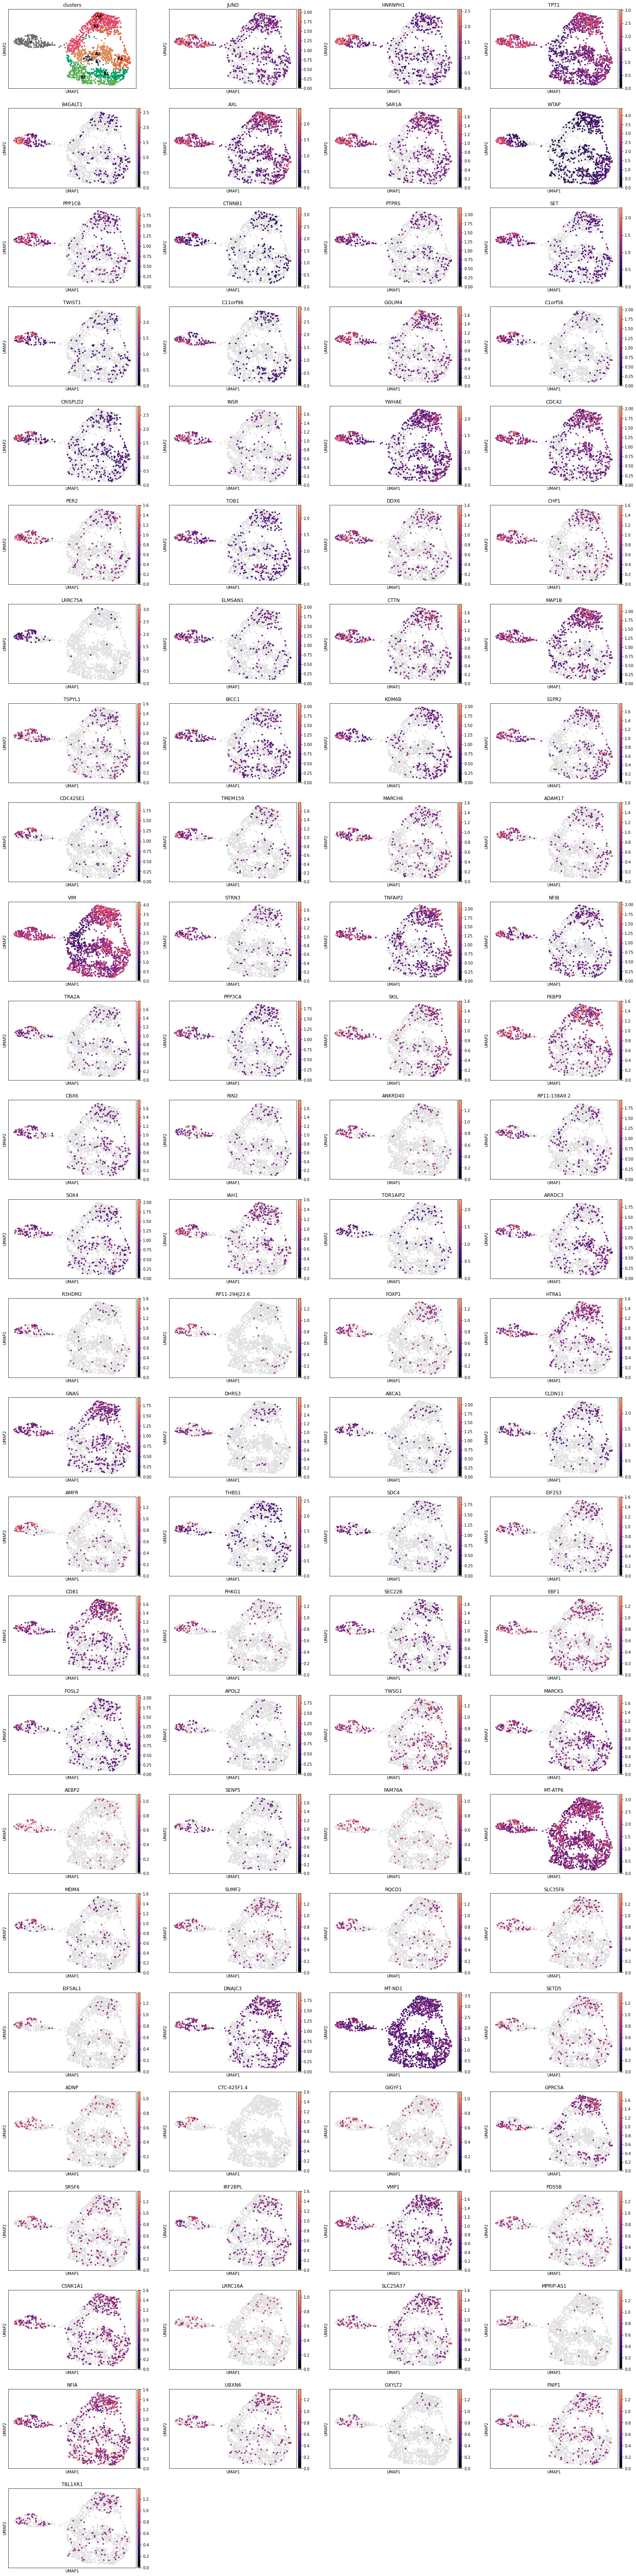

In [231]:
sc.pl.umap(adata_vors_fb, color=['clusters'] + list(adata_vors_fb.uns['rank_genes_groups']['names']['F'][:100]), 
           cmap=magma, legend_loc='on data', use_raw=False) 

### He et al. 2020

#### Colocallization of COL18A1, COL6A5, CCL19

In [ ]:
genes = ['COL18A1', 'COL6A5', 'CCL19']
sc.pl.umap(adata_tabib_fb, color=['leiden'] + genes, cmap=magma, legend_loc='on data', use_raw=False) 
sc.pl.umap(adata_vors_fb, color=['leiden'] + genes, cmap=magma, legend_loc='on data', use_raw=False) 
sc.pl.umap(adata_sole_young_fb, color=['leiden'] + genes, cmap=magma, legend_loc='on data', use_raw=False) 
sc.pl.umap(adata_he_fb, color=['leiden'] + genes, cmap=magma, legend_loc='on data', use_raw=False) 

Interestingly, CCL19 barely colocalizes with COL6A5 in the rest of datasets, but it does in He et al.

In [ ]:
sc.tl.rank_genes_groups(adata_he_fb, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_he_fb, dendrogram=False, n_genes=70, use_raw=False)

* I don't like cluster 0. It has many RPS/MT, and all of its DEGs are also expressed by other clsuters.It expreses PI16/CCN5/C3, so it can be the SFRP2+/WISP2+ cluster; but it does not express SLPI or WIF, so it somewhat inconsistent. There are other genes that express WISP2-related genes, but they don't express GPX3.
* Clusters 1, 2 express CRYAB/ADM, which are expressed in the WISP2 cluster of the rest of datasets.
    * Clusters 5, 10 and 15 might also be annexed because they express DPT, CP and CTHRC1. CTHRC1 is mapped exclusively to WISP2 clsuter, whereas DPT is mapped to WISP2+ cluster and APOE+ cluster (4, 8, 3, 11).
* The two immune parts (CCL19/C3/APOE VS APOE/APOC1/APOD) can be divided into
    * APOE/C3/CCL19 - 4 + 8 + 12
    * APOE/APOC1/APOD - 3 + 11 + 17
* Also, cluster 13 is APOD / ANGPTL7 / FGFBP2 / SCN7A. It also expressed NDUFA4L2, and other markers from other cell types which might imply a slight contamination. (These markers don't collocalize with the rest of markers).
* Cluster 9 is strange. It expresses PABPC1, SLC25A5, RPSA, SNHG5 and NACA. Those genes are thoroughly expressed in most datasets, but interestingly **it is a cluster of Solé-Boldo dataset**
* Clusters 6 and 7 can be joined (cluster 7 expressed jointly to 6 all DEGs) and coexpress DPEP1, POSTN, COL11A1.
* Cluster 14 maps to the typical COMP cluster, but very roughly.
* Cluster 16 expresses COCH ASPN

In [ ]:
dict_reverse_mappings = {'H0': ['0'], 'H1': ['1', '2', '5', '10', '15'], 'H2': ['3', '11', '17'], 'H3': ['4', '8', '12'], 
                         'H4': ['6', '7'], 'H5': ['9'], 'H6': ['13'], 'H7': ['14'], 'H8': ['16'],}
 
dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key
        
adata_he_fb.obs['robust_clustering_1'] = [dict_mappings[i] for i in adata_he_fb.obs['leiden']]
sc.pl.umap(adata_he_fb, color=['robust_clustering_1'], cmap=magma, legend_loc='on data')

In [ ]:
sc.pl.umap(adata_he_fb, color=['robust_clustering_1', 'AXIN2', 'PTK7'], cmap=magma, legend_loc='on data')

In [ ]:
sc.tl.rank_genes_groups(adata_he_fb, 'robust_clustering_1', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_he_fb, dendrogram=False, n_genes=70, use_raw=False)

In [ ]:
dict_reverse_mappings = {'A': ['H0', 'H1', 'H7'], 'B': ['H2', 'H3'], 'C': ['H4', 'H6', 'H8'], 'E': ['H5']}

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key
        
adata_he_fb.obs['axes'] = [dict_mappings[i] for i in adata_he_fb.obs['robust_clustering_1']]
adata_he_fb.uns['axes_colors'] = ['#9a1549', '#00764b', '#002562', '#b21b95']

sc.pl.umap(adata_he_fb, color=['axes'], cmap=magma, legend_loc='on data', legend_fontsize=16)

In [ ]:
sc.tl.rank_genes_groups(adata_he_fb, 'axes', method='wilcoxon')
sc.pl.rank_genes_groups_tracksplot(adata_he_fb, dendrogram=False, n_genes=70, use_raw=False)

In [ ]:
dict_reverse_mappings = {'A': ['H0', 'H7', 'H1'],
                         'B1': ['H3'], 'B2': ['H2'], 
                         'C1': ['H4'], 'C2': ['H8'], 'C4': ['H6'],
                         'E': ['H5']}

dict_mappings = {}

for key, val in dict_reverse_mappings.items():
    for val_i in val:
        dict_mappings[val_i] = key
        
adata_he_fb.obs['clusters'] = [dict_mappings[i] for i in adata_he_fb.obs['robust_clustering_1']]

adata_he_fb.uns['clusters_colors'] = ['#9a1549', '#009f61', '#54ab4c', '#008aac', '#006aad', '#3fb4c1', '#b21b95']

sc.pl.umap(adata_he_fb, color=['clusters'], cmap=magma, legend_loc='on data', legend_fontsize=16)

#### Getting DEGs for cluster E

In [214]:
sc.tl.rank_genes_groups(adata_he_fb, 'clusters', method='wilcoxon', groups=['E'], reference='rest', n_genes=200)

In [ ]:
sc.pl.umap(adata_he_fb, color=['clusters'] + list(adata_he_fb.uns['rank_genes_groups']['names']['E'][:100]), 
           cmap=magma, legend_loc='on data', use_raw=False) 

In [ ]:
sc.pl.umap(adata_he_fb, color=['clusters'] + list(adata_he_fb.uns['rank_genes_groups']['names']['E'][100:]), 
           cmap=magma, legend_loc='on data', use_raw=False) 

# Figure production

In [ ]:
def create_plot_axis(genes):
    names = ['Tabib', 'Solé-Boldo', 'Vorstandlechner', 'He']
    fig, axs = plt.subplots(1 + len(genes), 4, figsize=(4*4, (1 + len(genes))*3))
    for adata_ix, adata in enumerate([adata_tabib_fb, adata_sole_young_fb, adata_vors_fb, adata_he_fb]):
        sc.pl.umap(adata, color=['axes',] , cmap=magma, legend_loc='on data', ax=axs[0][adata_ix], show=False, title=names[adata_ix], 
                   legend_fontsize=16, legend_fontoutline=3)
        
        for gene_ix, gene in enumerate(genes):
            try:
                sc.pl.umap(adata, color=gene , cmap=magma, legend_loc='on data', ax=axs[gene_ix + 1][adata_ix], show=False, use_raw=False)
            except:
                pass
            
    plt.tight_layout()
    fig.savefig('images/'+'_'.join(genes)+'png', dpi=300)
    
def create_plot_cluster(genes, clusters=[]):
    names = ['Tabib', 'Solé-Boldo', 'Vorstandlechner', 'He']
    
    fig, axs = plt.subplots(1 + len(genes), 4, figsize=(4*4, (1 + len(genes))*3))
    for adata_ix, adata in enumerate([adata_tabib_fb, adata_sole_young_fb, adata_vors_fb, adata_he_fb]):       
        sc.pl.umap(adata, color=['clusters',] , cmap=magma, legend_loc='on data', ax=axs[0][adata_ix], show=False, title=names[adata_ix], 
                  legend_fontsize=12, legend_fontoutline=2)
        
        for gene_ix, gene in enumerate(genes):
            try:
                if len(clusters):
                    sc.pl.umap(adata, color=gene , cmap=magma, legend_loc='on data', ax=axs[gene_ix + 1][adata_ix], show=False, use_raw=False, 
                           title = f'{gene} ({clusters[gene_ix]})')
                else:
                    sc.pl.umap(adata, color=gene , cmap=magma, legend_loc='on data', ax=axs[gene_ix + 1][adata_ix], show=False, use_raw=False, 
                           title = f'{gene}')
            except:
                pass
            
    plt.tight_layout()
    fig.savefig('images/'+'_'.join(genes)+'png', dpi=300)


### Figure 1: Representation of major axes with principal representative genes

In [ ]:
create_plot_axis(['SFRP2', 'APOE', 'SFRP1'])

### Figure 2: Representation of markers of axis A populations

In [ ]:
create_plot_cluster(['SLPI', 'COMP', 'WIF1', 'SFRP4'], ['A1', 'A2', 'A3', 'A4'])

### Figure 3: Representation of markers of axis B populations

In [ ]:
create_plot_cluster(['ITM2A', 'CCL2', 'CCL19', 'CTSH'], ['B1', 'B1', 'B2', 'B2'])

### Figure 4: Representation of markers of axis C populations

In [ ]:
create_plot_cluster(['COL11A1', 'COCH', 'POSTN', 'TM4SF1'], ['C1', 'C2', 'C3', 'C4'])

## Supplementary figures

In [ ]:
create_plot_axis(['ELN', 'MMP2', 'QPCT', 'SFRP2'])
create_plot_axis(['APOE', 'C7', 'CYGB', 'IGFBP7'])
create_plot_axis(['DKK3', 'SFRP1', 'TNMD', 'TNN'])

In [ ]:
create_plot_cluster(['IGFBP6', 'PI16', 'SLPI', 'WISP2'])
create_plot_cluster(['ELN', 'RGCC', 'SGCA', 'WIF1'])
create_plot_cluster(['APCDD1', 'COL18A1', 'COMP', 'NKD2'])
create_plot_cluster(['FBN1', 'PCOLCE2', 'PRG4', 'SFRP4'])

In [ ]:
create_plot_cluster(['CCL2', 'ITM2A', 'PLA2G2A', 'SOD2'])
create_plot_cluster(['CCL19', 'CD74', 'CTSH', 'RBP5'])

In [ ]:
create_plot_cluster(['COL11A1', 'DPEP1', 'TNMD', 'WFDC1'])
create_plot_cluster(['COCH', 'CRABP1', 'FIBIN', 'RSPO4'])
create_plot_cluster(['ASPN', 'F2R', 'GPM6B', 'POSTN'])
create_plot_cluster(['ANGPTL7', 'APOD', 'C2orf40', 'TM4SF1'])

In [ ]:
create_plot_cluster(['CHRDL1', 'GDF10', 'ITM2A', 'OGN'])
create_plot_cluster(['ADAMTS5', 'HSPH1', 'MIR22HG', 'MME'])
create_plot_cluster(['EEF1B2', 'FXYD3', 'KRT14'])
create_plot_cluster(['B4GALT1', 'CTNNB1', 'HNRNPH1', 'WTAP'])

In [ ]:
create_plot_cluster(['FMO1', 'LSP1'])

## Table S1
This is the table of the *robust* DEGs of axes in all datasets.
We will select DEGs common between datasets, and manually curate them. The last thre cells are the curated list of genes.

In [ ]:
def create_table(list_list_genes, list_columns, clus_ax, list_adatas=[adata_tabib_fb, adata_sole_young_fb, adata_vors_fb, adata_he_fb], 
                 list_adata_letters=['T', 'S', 'V', 'H']):
    df_supercolumns = [i for i in list_columns for j in range(len(list_adatas) + 1)]
    df_subcolumns = [i for j in range(len(list_columns)) for i in ['DEGs'] + list_adata_letters]
    
    cols = pd.MultiIndex.from_tuples(list(zip(*[df_supercolumns, df_subcolumns])), names=[clus_ax, 'dataset'])
    df = pd.DataFrame(index=range(max([len(i) for i in list_list_genes])), columns=cols)
    
    for column_idx, column in enumerate(list_columns):
        list_genes = list_list_genes[column_idx]
        
        for gene_idx, gene in enumerate(list_genes):
            df[column, 'DEGs'].loc[gene_idx] = gene
            
            for adata, letter in zip(list_adatas, list_adata_letters):
                try:
                    gene_loc = np.argwhere(adata.uns['rank_genes_groups']['names'][column] == gene)[0][0]
                    pval = adata.uns['rank_genes_groups']['pvals'][column][gene_loc]
                    logfold = adata.uns['rank_genes_groups']['logfoldchanges'][column][gene_loc]
                    df[column, letter].loc[gene_idx] = f'{pval:.2e} ({logfold:.2f})'
                except:
                    df[column, letter].loc[gene_idx] = f'-'
                
                
                
    return df

In [ ]:
# YOU MUST RUN THIS FIRST!!!!!!
sc.tl.rank_genes_groups(adata_tabib_fb, groupby='axes', method='wilcoxon', n_genes=200)
sc.tl.rank_genes_groups(adata_sole_young_fb, groupby='axes', method='wilcoxon', n_genes=200)
sc.tl.rank_genes_groups(adata_vors_fb, groupby='axes', method='wilcoxon', n_genes=200)
sc.tl.rank_genes_groups(adata_he_fb, groupby='axes', method='wilcoxon', n_genes=200)

In [ ]:
list_genes_axis_A = set(adata_tabib_fb.uns['rank_genes_groups']['names']['A'])
list_genes_axis_B = set(adata_tabib_fb.uns['rank_genes_groups']['names']['B'])
list_genes_axis_C = set(adata_tabib_fb.uns['rank_genes_groups']['names']['C'])

for adata in [adata_sole_young_fb, adata_vors_fb]:    
    list_genes_axis_A = list_genes_axis_A & set(adata.uns['rank_genes_groups']['names']['A'])
    list_genes_axis_B = list_genes_axis_B & set(adata.uns['rank_genes_groups']['names']['B'])
    
for adata in [adata_sole_young_fb, adata_he_fb]:    
    list_genes_axis_C = list_genes_axis_C & set(adata.uns['rank_genes_groups']['names']['C'])

In [ ]:
# AXIS A
list_genes_A = ['AEBP1','AQP1','CAPZB','CD9','COL1A1','COL1A2','COL6A1','COL6A2',
'CTHRC1','ELN','FBN1','LAMP1','MMP2','NBL1','PAM','QPCT','RGCC','SFRP2','SPARC','THBS2','TSPAN4',]
create_plot_axis(list_genes_A)

In [ ]:
# AXIS B
list_genes_B = ['APOE','BTG1','C3','C7','CCDC146','CXCL12','CYGB','FGF7',
'GEM','GGT5','IGFBP7','IRF1','RARRES2','SOCS3','TMEM176A','TMEM176B','TNFSF13B',]
create_plot_axis(list_genes_B)

In [ ]:
# AXIS C
list_genes_C = ['CDH11','COL1A1','COL1A2','DKK3','EMID1','GPM6B','INHBA', 'PRSS23', 'SFRP1','SPARCL1','TNMD','TNN',]
create_plot_axis(list_genes_C)

In [ ]:
df_axis = create_table([list_genes_A, list_genes_B, list_genes_C], ['A', 'B', 'C'], 'axis')
df_axis.to_csv('tables/TableS1.csv', sep=';')

## Table S2
This is the table of the *robust* DEGs of clusters in axis A in all datasets.
We will select DEGs common between datasets, and manually curate them. The last thre cells are the curated list of genes.

In [ ]:
sc.tl.rank_genes_groups(adata_tabib_fb, groupby='clusters', method='wilcoxon', n_genes=200)
sc.tl.rank_genes_groups(adata_sole_young_fb, groupby='clusters', method='wilcoxon', n_genes=200)
sc.tl.rank_genes_groups(adata_vors_fb, groupby='clusters', method='wilcoxon', n_genes=200)
sc.tl.rank_genes_groups(adata_he_fb, groupby='clusters', method='wilcoxon', n_genes=200)

In [ ]:
df_tabib = pd.DataFrame(adata_tabib_fb.uns['rank_genes_groups']['names'])
df_sole = pd.DataFrame(adata_sole_young_fb.uns['rank_genes_groups']['names'])
df_vors = pd.DataFrame(adata_vors_fb.uns['rank_genes_groups']['names'])
df_he = pd.DataFrame(adata_he_fb.uns['rank_genes_groups']['names'])

In [ ]:
list_genes_A1 = set(df_tabib['A1'].values)
list_genes_A2 = set(df_tabib['A2'].values)
list_genes_A3 = set(df_tabib['A3'].values)
list_genes_A4 = set(df_tabib['A4'].values)

for df in [df_sole, df_vors]:    
    list_genes_A1 = list_genes_A1 & set(df['A1'].values)
    list_genes_A2 = list_genes_A2 & set(df['A2'].values)
    list_genes_A3 = list_genes_A3 & set(df['A3'].values)

for df in [df_vors]:
    list_genes_A4 = list_genes_A4 & set(df['A4'].values)

In [ ]:
# CLUSTER A1
list_genes_A1 = ['ANGPTL5', 'C1QTNF3', 'CD151', 'CD55', 'CD99', 'CPE', 'CTSB', 'CYBRD1', 'DCN', 'FBLN1', 'FGL2', 
'GPX3', 'GSN', 'IGFBP6', 'LOX', 'MFAP5', 'MGST1', 'MMP2', 'OLFML3', 'PDGFRL', 'PI16', 'PIGT', 'PODN', 'REXO2', 'SCARA5', 
'SERPINF1', 'SLPI', 'TSPAN8', 'WISP2', 
]
create_plot_cluster(list_genes_A1)

In [ ]:
# CLUSTER A2
list_genes_A2 = ['APCDD1', 'AXIN2', 'C1orf198', 'CLEC2A', 'COL13A1', 'COL18A1', 'COL23A1', 'COMP', 
'CTSC', 'CYB26B1', 'EMX2', 'F13A1', 'GNG11', 'GREM2', 'HSPB3', 'LAMC3', 'NKD2', 'PTK7', 'RGS3', 'RSPO1', 'STC2', 'TGFBI', ]
create_plot_cluster(list_genes_A2)

In [ ]:
# CLUSTER A3
list_genes_A3 = ['CD9', 'COL6A1', 'ELN', 'LEPR', 'RGCC', 'SGCA', 'WIF1', ]
create_plot_cluster(list_genes_A3)

In [ ]:
# CLUSTER A4
list_genes_A4 = ['C1QTNF3','FBN1', 'FSTL1', 'HSD3B7', 'IGFBP6', 'ISLR', 'MFAP5', 'PCOLCE2', 'PRG4', 'PRSS23', 'SFRP4', 'TNXB', ]
create_plot_cluster(list_genes_A4)

In [ ]:
df_axis = create_table([list_genes_A1, list_genes_A2, list_genes_A3, list_genes_A4], ['A1', 'A2', 'A3', 'A4'], 'cluster')
df_axis.to_csv('tables/TableS2.csv', sep=';')

## Table S3
This is the table of the *robust* DEGs of clusters in axis B in all datasets.
We will select DEGs common between datasets, and manually curate them. The last thre cells are the curated list of genes.

In [ ]:
list_genes_B1 = set(df_tabib['B1'].values)
list_genes_B2 = set(df_tabib['B2'].values)

for df in [df_vors]:    
    list_genes_B1 = list_genes_B1 & set(df['B1'].values)
    list_genes_B2 = list_genes_B2 & set(df['B2'].values)


In [ ]:
# CLUSTER B1
list_genes_B1 = ['ARL6IP1', 'CCL2', 'DNAJA1', 'ERRFI1', 'GPC3', 'ITM2A', 'MCL1', 'MYC', 'PLA2G2A', 'PLIN2', 'SOD2', 'UAP1', ]
create_plot_cluster(list_genes_B1)

In [ ]:
# CLUSTER B2
list_genes_B2 = ['BIRC3', 'BTG1', 'C3', 'CCL19', 'CCL2', 'CCL2', 'CD74', 'CTSH', 'IGFBP3', 'OLFM2', 'PSME2', ]
create_plot_cluster(list_genes_B2)

In [ ]:
df_axis = create_table([list_genes_B1, list_genes_B2, ], ['B1', 'B2'], 'cluster')
df_axis.to_csv('tables/TableS3.csv', sep=';')

## Table S4
This is the table of the *robust* DEGs of clusters in axis C in all datasets.
We will select DEGs common between datasets, and manually curate them. The last thre cells are the curated list of genes.

In [ ]:
list_genes_C1 = set(df_tabib['C1'].values)
list_genes_C2 = set(df_tabib['C2'].values)
list_genes_C3 = set(df_tabib['C3'].values)
list_genes_C4 = set(df_tabib['C4'].values)

for df in [df_sole]:    
    list_genes_C1 = list_genes_C1 & set(df['C1'].values)
    list_genes_C2 = list_genes_C2 & set(df['C2'].values)
    list_genes_C4 = list_genes_C4 & set(df['C4'].values)   
    list_genes_C3 = list_genes_C3 & set(df['C3'].values)


In [ ]:
# CLUSTER C1
list_genes_C1 = ['CCND1', 'CDH11', 'COL11A1', 'COL5A2', 'DPEP1', 'EDNRA', 'GPC3', 'LAMC3', 'MEF2C', 'MME', 'POSTN', 'SPARC', 'STMN1', ]
create_plot_cluster(list_genes_C1)

In [ ]:
# CLUSTER C2
list_genes_C2 = ['ADAMTS6', 'ARHGAP15', 'CADM2', 'CCK', 'CHADL', 'CLEC14A', 'COCH', 'CRABP1', 'DKK2', 'EMID1', 
'FIBIN', 'FZD1', 'GAP43', 'HSPA2', 'LEPREL1', 'LIPA', 'MEIS2', 'MEOX2', 'MKX', 'NDNF', 'NECAB1', 'OGN', 
'PCSK1N', 'PLXDC1', 'PPAPDC1B', 'PRRG4', 'RHPN1', 'RSPO4', 'SLC22A16', 'SLITRK6', 'SYTL2',]
create_plot_cluster(list_genes_C2)

In [ ]:
# CLUSTER C3
list_genes_C3 = ['ASPN', 'BGN', 'C9orf3', 'DIO2', 'DKK2', 'F2R', 'FIBIN', 'GPM6B', 'LRRC15', 'LTBP2', 'MARCKS', 'PLEKHH2', 'PMEPA1', 'POSTN', ]
create_plot_cluster(list_genes_C3)

In [ ]:
# CLUSTER C4
list_genes_C4 = ['ANGPTL7', 'APOD', 'C2orf40', 'CLDN1', 'CYP1B1', 'EBF2', 'EIF4A3', 'FGFBP2', 'IFI27', 
'KLK1', 'PODNL1', 'SCN7A', 'SFRP4', 'TAGLN', 'TENM2', 'TM4SF1' ]
create_plot_cluster(list_genes_C4)

In [ ]:
df_axis = create_table([list_genes_C1, list_genes_C2, list_genes_C3, list_genes_C4,], ['C1', 'C2', 'C3', 'C4'], 'cluster')
df_axis.to_csv('tables/TableS4.csv', sep=';')

## Export adatas

In [ ]:
os.makedirs('adatas', exist_ok=True)

In [ ]:
adata_he_fb.write_h5ad('adatas/he_fb.h5ad')
adata_phil_fb.write_h5ad('adatas/philippeos_fb.h5ad')
adata_tabib_fb.write_h5ad('adatas/tabib_fb.h5ad')
adata_vors_fb.write_h5ad('adatas/vorstandlechner_fb.h5ad')
adata_sole_young_fb.write_h5ad('adatas/sole_fb.h5ad')